In [22]:
# import packages 
import os, sys, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from DGXutils import GetLowestGPU, GetFileNames

sys.path.append('../')

from utils.dataset import *
from utils.model import *

In [23]:
# load data
model_type = "gxe_model"
if model_type == "e_model":
    test = E_Dataset(split='sub')
elif model_type == "g_model":
    test = G_Dataset(split="sub")
else:
    test = GxE_Dataset(split="sub")
test_loader = DataLoader(test,
                         batch_size=64,
                         shuffle=False)

In [24]:
with open(f'../logs/{model_type}/log.txt', 'r') as f:
    logs = f.readlines()
    logs = [l.strip() for l in logs][1:]
logs = [l.split(',') for l in logs]
logs = np.array(logs).astype(float)
epochs, train_loss, val_loss = logs.T
epochs = epochs.astype(int)
epochs = np.arange(0, epochs.max() + 1, 1)
best_epoch = int(epochs[np.argmin(val_loss)])

In [25]:
best_epoch

16

In [26]:
with open(f'../logs/{model_type}/log.txt', 'r') as f:
    logs = f.readlines()
    logs = [l.strip() for l in logs][1:]
logs = [l.split(',') for l in logs]
logs = np.array(logs).astype(float)
epochs, train_loss, val_loss = logs.T
epochs = epochs.astype(int)
epochs = np.arange(0, epochs.max() + 1, 1)
best_epoch = int(epochs[np.argmin(val_loss)])

In [27]:
# load model + weights
device = GetLowestGPU()

checkpoint_path = f'../checkpoints/{model_type}/checkpoint_{best_epoch}.pt'
checkpoint = torch.load(checkpoint_path)["model"]

if model_type == "e_model":
    model = GxE_Transformer(config=TransformerConfig, g_enc=False).to(device)
elif model_type == "g_model":
    config = TransformerConfig(block_size=len(test[0][0]['g_data']))
    model = GxE_Transformer(config=config, e_enc=False).to(device)
else:
    config = TransformerConfig(block_size=len(test[0][0]['g_data']))
    model = GxE_Transformer(config=config).to(device)
model.load_state_dict(checkpoint)

/tmp/ipykernel_3267385/4186446821.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)["model"]


<All keys matched successfully>

In [28]:
# evaluate on test set
preds = pd.DataFrame({'Env':[], 'Hybrid':[], 'Yield_Mg_ha':[]})

model.eval()
with torch.no_grad():
    # loop through
    for xb, yb in tqdm(test_loader):
        
        # get things on device
        for key, value in xb.items():
            xb[key] = value.to(device)
        pred = model(xb).detach().cpu().numpy().squeeze().tolist()
        yb['Yield_Mg_ha'] = pred
        yb = pd.DataFrame(yb)
        preds = pd.concat([preds, yb], axis=0)
preds.to_csv(f'../data/results/pk_{model_type}_submission.csv', index=False)

  0%|          | 0/158 [00:00<?, ?it/s]

In [29]:
preds.head()

,Env,Hybrid,Yield_Mg_ha
0,DEH1_2024,01CSI6/LH287,10.361548
1,DEH1_2024,01DIB2/LH287,10.612765
2,DEH1_2024,01DIB2/PHP02,9.818007
3,DEH1_2024,2369/LH123HT,12.661183
4,DEH1_2024,2FACC/PHP02,9.584599


In [30]:
# get yield by location
loc_yield = preds.drop(columns=['Hybrid'])
loc_yield = loc_yield.groupby(loc_yield['Env']).mean().reset_index(drop=False)
loc_yield.to_csv(f'../data/results/pk_{model_type}_yield_by_location.csv', index=False)

In [31]:
# compare to ken, roshan's predictions
roshan = pd.read_csv('../data/results/roshan_submission.csv')
ken = pd.read_csv('../data/results/ken_submission.csv')
merged = pd.merge(roshan, ken, on=['Env', 'Hybrid'], suffixes=('_roshan', '_ken'))
merged = pd.merge(merged, preds, on=['Env', 'Hybrid'], suffixes=('_roshan', '_pk'))
merged.head()

,Env,Hybrid,Yield_Mg_ha_roshan,Yield_Mg_ha_ken,Yield_Mg_ha
0,DEH1_2024,01CSI6/LH287,11.879029,8.623690,10.361548
1,DEH1_2024,01DIB2/LH287,12.136417,9.112560,10.612765
2,DEH1_2024,01DIB2/PHP02,10.337003,9.037066,9.818007
3,DEH1_2024,2369/LH123HT,12.191640,10.381960,12.661183
4,DEH1_2024,2FACC/PHP02,9.892350,8.712988,9.584599


In [32]:
len(ken), len(roshan), len(preds)

(10057, 10057, 10057)

In [33]:
pearsonr(merged['Yield_Mg_ha'], merged['Yield_Mg_ha_roshan'])

PearsonRResult(statistic=np.float64(0.7188419544121762), pvalue=np.float64(0.0))

In [34]:
pearsonr(merged['Yield_Mg_ha'], merged['Yield_Mg_ha_ken'])

PearsonRResult(statistic=np.float64(0.7834865920319982), pvalue=np.float64(0.0))

In [35]:
pearsonr(merged['Yield_Mg_ha_roshan'], merged['Yield_Mg_ha_ken'])

PearsonRResult(statistic=np.float64(0.8311958918332241), pvalue=np.float64(0.0))

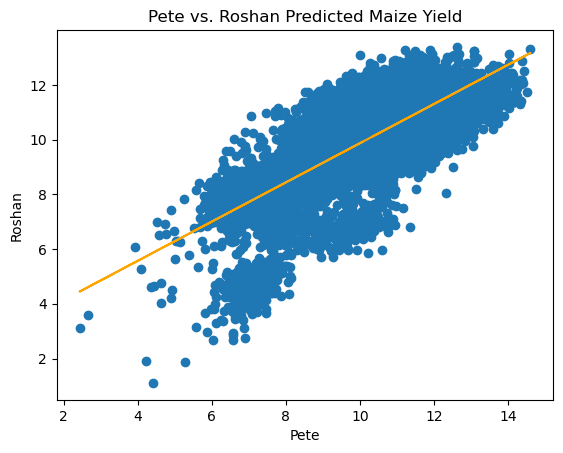

In [36]:
#find line of best fit
actuals = merged['Yield_Mg_ha']
preds = merged['Yield_Mg_ha_roshan']
a, b = np.polyfit(actuals, preds, 1)

#add points to plot
plt.scatter(actuals, preds)

#add line of best fit to plot
plt.plot(actuals, a*actuals+b, color="orange")

plt.title("Pete vs. Roshan Predicted Maize Yield")
plt.xlabel("Pete")
plt.ylabel("Roshan")
plt.show()

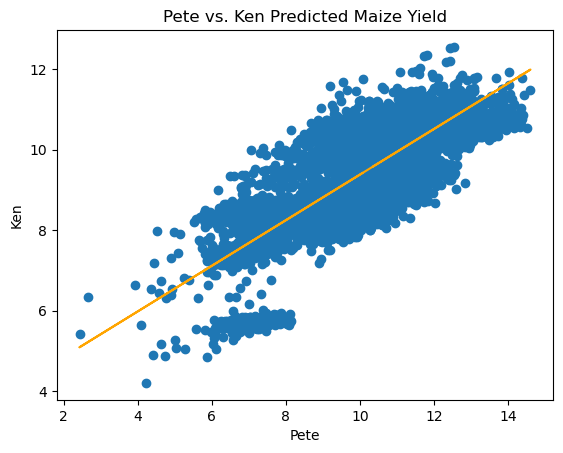

In [37]:
#find line of best fit
actuals = merged['Yield_Mg_ha']
preds = merged['Yield_Mg_ha_ken']
a, b = np.polyfit(actuals, preds, 1)

#add points to plot
plt.scatter(actuals, preds)

#add line of best fit to plot
plt.plot(actuals, a*actuals+b, color="orange")

plt.title("Pete vs. Ken Predicted Maize Yield")
plt.xlabel("Pete")
plt.ylabel("Ken")
plt.show()

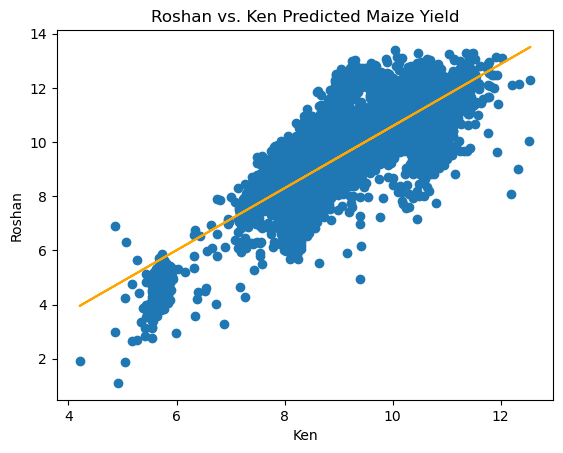

In [38]:
#find line of best fit
actuals = merged['Yield_Mg_ha_ken']
preds = merged['Yield_Mg_ha_roshan']
a, b = np.polyfit(actuals, preds, 1)

#add points to plot
plt.scatter(actuals, preds)

#add line of best fit to plot
plt.plot(actuals, a*actuals+b, color="orange")

plt.title("Roshan vs. Ken Predicted Maize Yield")
plt.xlabel("Ken")
plt.ylabel("Roshan")
plt.show()